# Credit Risk Analysis

This application aims to identify patterns which indicate if a client has difficulty paying their instalments which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc. This will ensure that the consumers capable of repaying the loan are not rejected. Identification of such applicants using EDA is the aim of this case study.

# Imports

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix

In [5]:
df = pd.read_csv("application_data.csv")
app = pd.read_csv("previous_application.csv")
des = pd.read_csv("columns_description.csv", encoding="latin1")
des.drop(columns="Unnamed: 0", axis=1, inplace=True)


# 1. Data Understanding

In [6]:
print("Dataset Info:")
print(df.info())
print("Dataset Description:")
print(df.describe())
print("Null Values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None
Dataset Description:
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000      1.471500e+05   
75%    367142.500000       0.000000       1.000000      2.025000e+05   
max    456255.000000       1.000000      19.000000      1.170000e+08   

         AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count  3.075110e+05  307499.000000     3.072330e

In [7]:
print(f"Number of loan applications are {df.shape[0]} in this dataframe.")
print(f"There are {df.shape[1]} attributes in this dataset.  ")


Number of loan applications are 307511 in this dataframe.
There are 122 attributes in this dataset.  


Below we are calculating the number of columns of each type in the dataset.

In [9]:
df.dtypes.value_counts().reset_index()

,index,count
0,float64,65
1,int64,41
2,object,16


Let's look at the top5 rows in our dataset.

In [10]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


### Missing Values

Let's understand how many missing values we have in each column in the dataset.

In [11]:
df_missing  = df.isnull().sum().reset_index()
df_missing.columns=["Columns_name", "null_count"] 
df_missing['null_percentage'] = (df_missing['null_count']/len(df))*100
df_missing_50 = df_missing.loc[(df_missing["null_percentage"] > 50)].sort_values(by="null_count",ascending=False).reset_index(drop=True)


Here we are dropping the columns which have more than 50% missing values.

In [12]:
df_new = df.drop(list(df_missing_50['Columns_name']), axis=1)
df_new.shape

(307511, 81)

We see that `NAME_TYPE_SUITE` has low volume of missing values. We can impute it with mode or leave it as it is. I am choosing to impute with the most frequent value.

In [13]:
mode = df_new.NAME_TYPE_SUITE.mode()[0]
df_new.NAME_TYPE_SUITE.fillna(mode, inplace=True)

After dropping the columns which had more than 50% missing values, our dataframe went from **122** columns to **81** columns now. Let's take a peek at the data now.

In [14]:
df_new.iloc[:, 0:21]

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,0.032561,-9327,-236,-8456.0,-1982
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,0.025164,-20775,365243,-4388.0,-4090
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,Unaccompanied,Working,Higher education,Separated,House / apartment,0.005002,-14966,-7921,-6737.0,-5150
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,0.005313,-11961,-4786,-2562.0,-931


In [15]:
print("Processed Data Info:")
print(df.info())

Processed Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None


# 2. Data Cleaning & Manipulation through Visualizations
## 2a. Clean the days_* columns

We see that Days_* columns are negative. Most likely this is because these columns take the difference between the start date and end date but not other way around.

We need to convert them into an absolute value.

In [16]:
#converting the negative days number to a positive number
df_new.DAYS_BIRTH = df_new.DAYS_BIRTH.abs()
df_new.DAYS_EMPLOYED = df_new.DAYS_EMPLOYED.abs()
df_new.DAYS_REGISTRATION = df_new.DAYS_REGISTRATION.abs()
df_new.DAYS_ID_PUBLISH = df_new.DAYS_ID_PUBLISH.abs()

Let's bin the age to create age buckets to understand the relationships to the target variable.

## 2b. Create buckets with age column

In [17]:
df_new["Age"] = df.DAYS_BIRTH / 365
df_new["Age"] = df_new["Age"].abs()
df_new["Age_bucket"] = pd.cut(df_new['Age'], [0, 20, 30, 40, 50, 60, 70, 999], 
                          labels= ["<20", "20-30", "30-40", "40-50", "50-60", "60-70", "70+"])
df_new['Age_bucket'] = df_new['Age_bucket'].astype(object)

## 2c. Data visualizations for many columns together

In [18]:
numerical_cols_df_new = df_new.select_dtypes(exclude=["object"])
categorical_cols_df_new = df_new.select_dtypes(include=["object", "category"])

Lets pick a subset of the columns from the `numerical_cols_df_new` dataset and visualize them to find patterns.

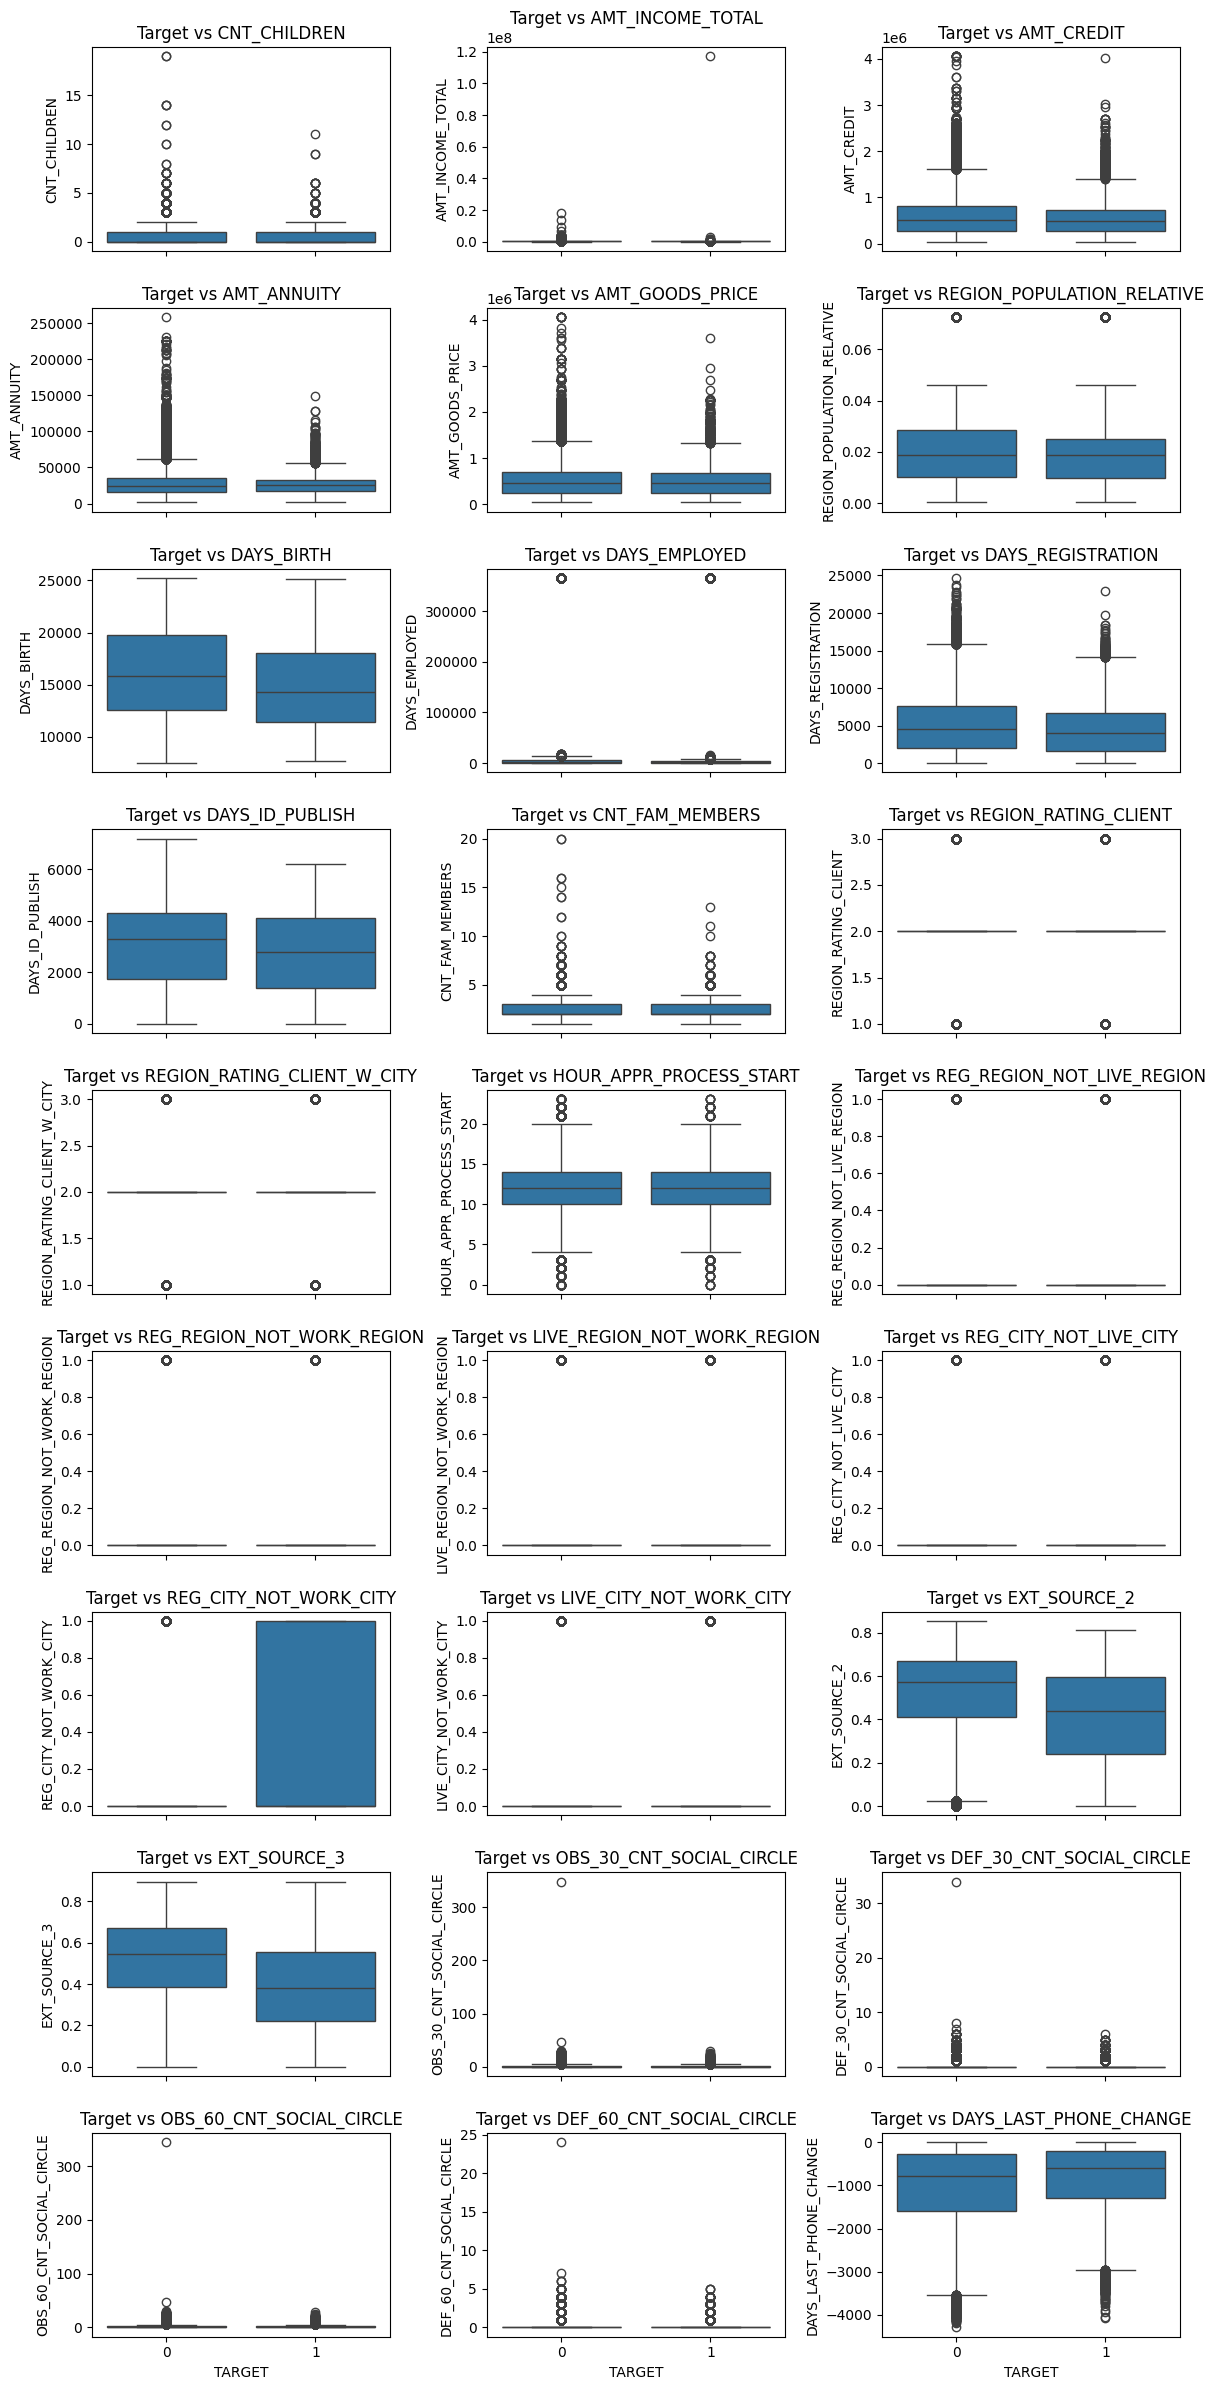

In [19]:
fig, axes = plt.subplots(9, 3, figsize=(12, 24), sharex=True)
for t, column in enumerate(['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START',
       'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION',
       'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY',
       'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2',
       'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
       'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
       'DAYS_LAST_PHONE_CHANGE']):
    sns.boxplot(ax=axes[int(t/3), t%3], data=numerical_cols_df_new, x="TARGET", y=column)
    axes[int(t/3), t%3].set_title("Target vs " +column)
    
plt.tight_layout()
plt.show()

From the above plots, it looks like there are many columns that have outliers and need data cleaning before drawing any conclusions.

Let's pick 3 variables for the scope of this exercise:
- CNT_CHILDREN
- AMT_INCOME_TOTAL
- OBS_30_CNT_SOCIAL_CIRCLE

Before we start cleaning the data, lets look at the categorical columns too.

In [20]:
categorical_cols_df_new['TARGET'] = df_new['TARGET']

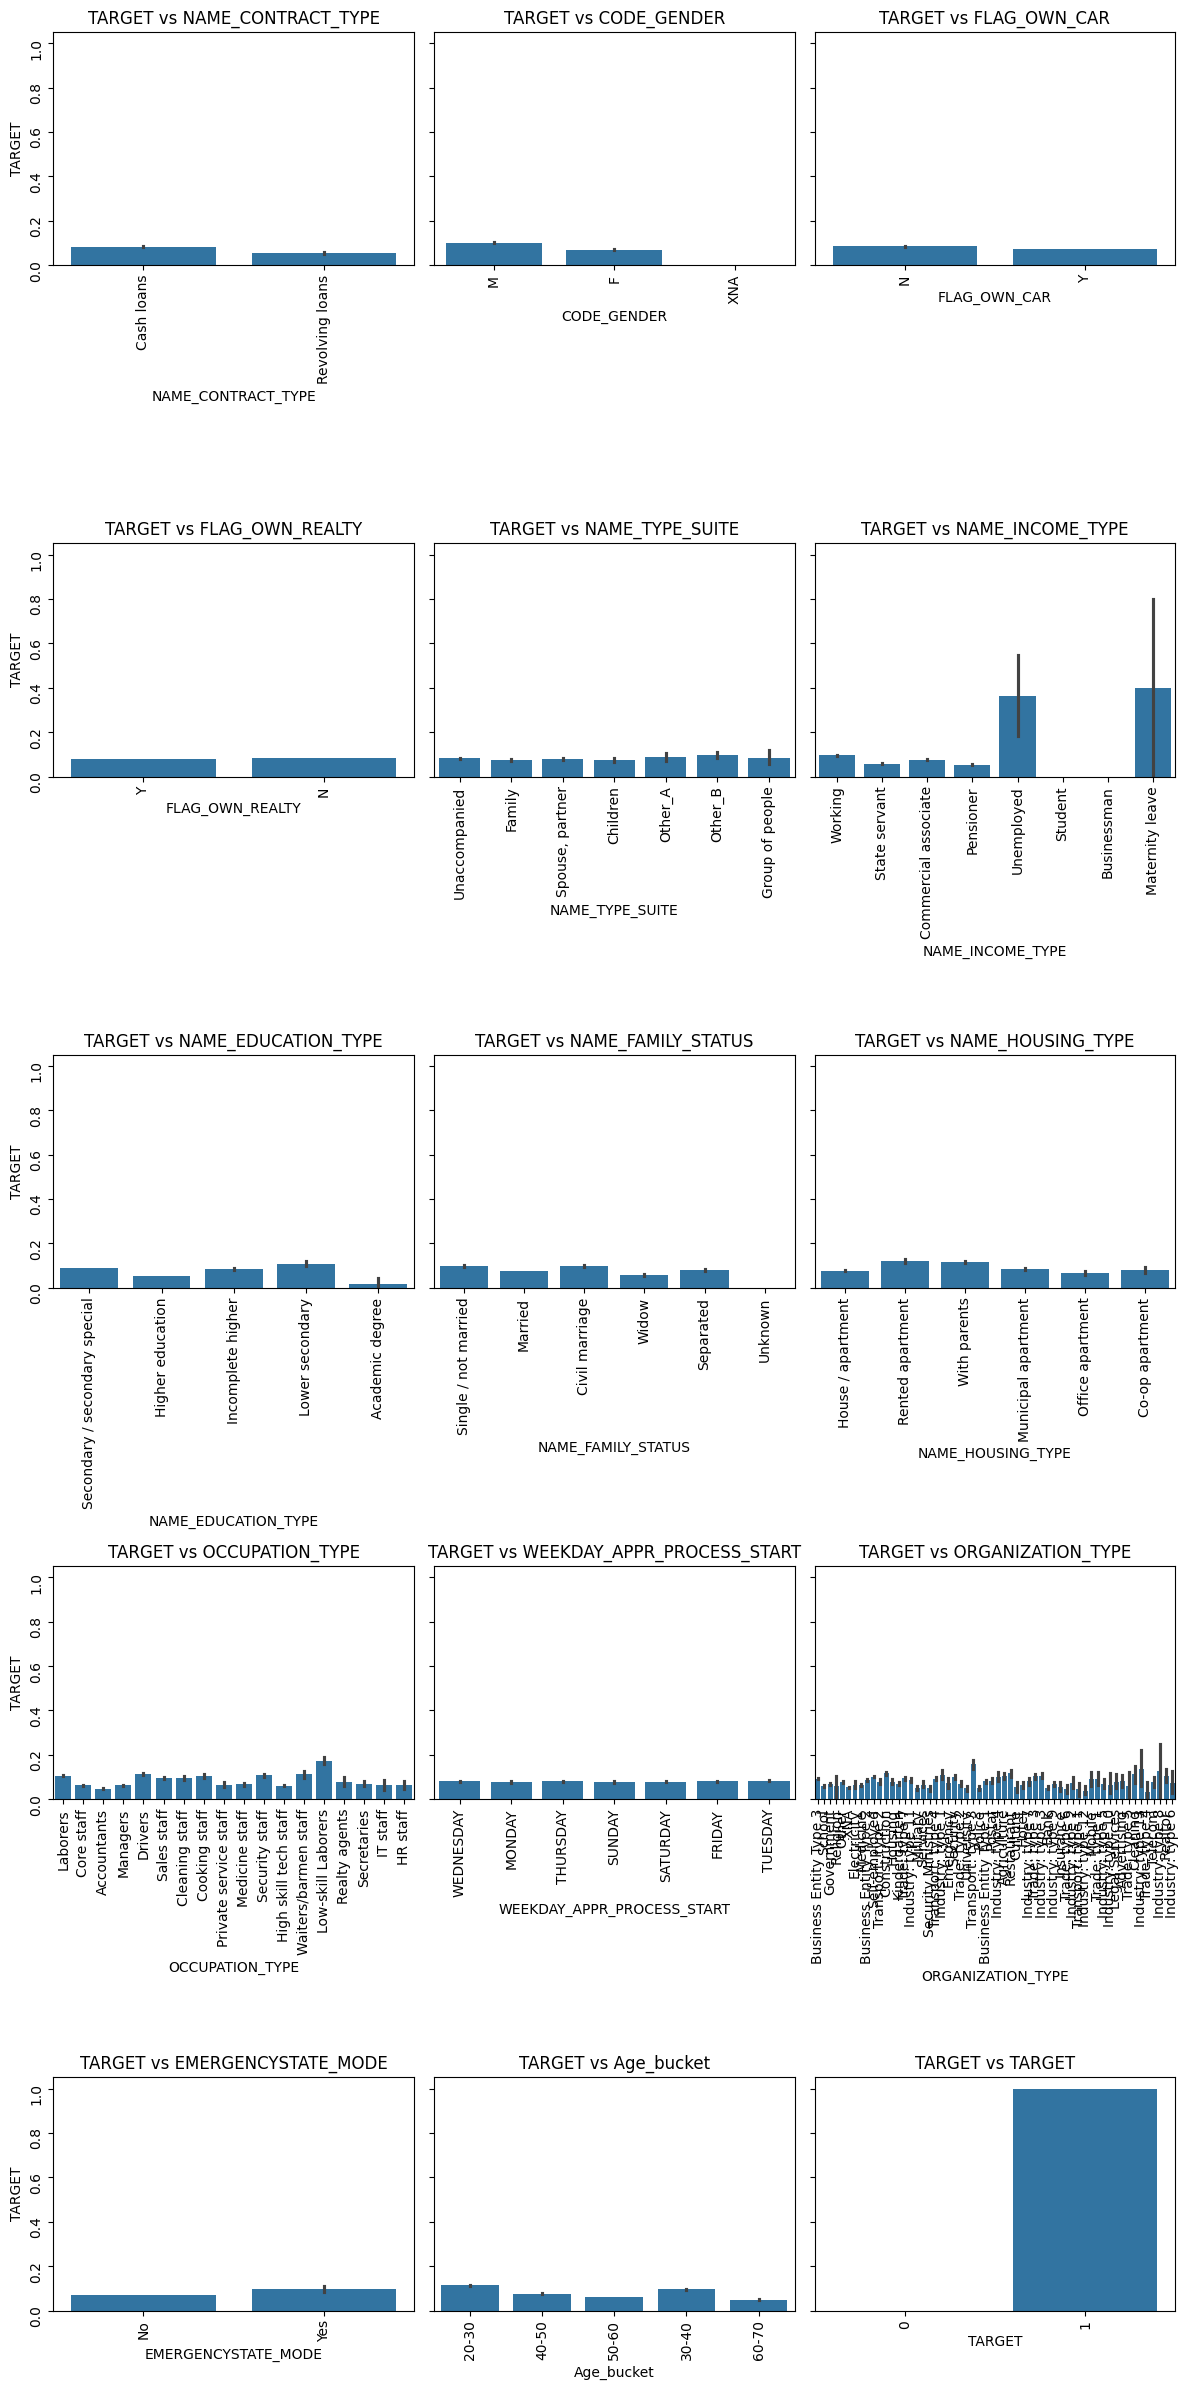

In [21]:
fig, axes = plt.subplots(5,3, figsize=(12, 24), sharey=True)

for t, column in enumerate(list(categorical_cols_df_new.columns)):
    sns.barplot(ax=axes[int(t/3), t%3], data=categorical_cols_df_new, x=column, y="TARGET", orient="v")
    axes[int(t/3), t%3].set_title("TARGET vs " + column)
    axes[int(t/3), t%3].tick_params(labelrotation=90)
plt.tight_layout()
plt.show()

Now that we have the plots ready, let's clean up a few columns, perform bivariate and multivariate analysis and draw conclusions.

## 2d. Data Cleaning

### (i) CNT_CHILDREN

In the above chart we see there are outliers in the count of children column across both the target values. 

We will clean up the outliers so that our analysis and insights below are valid and relevant to business stakeholders.

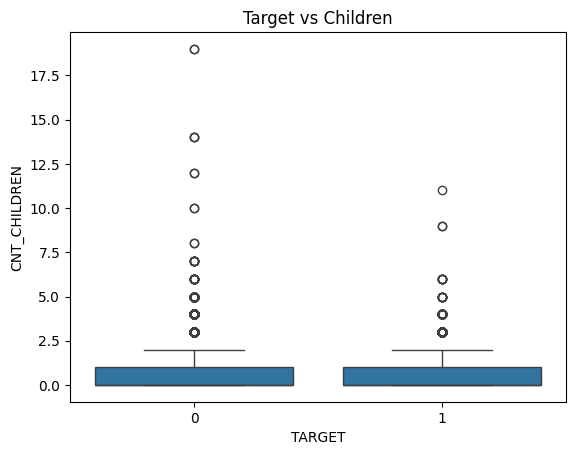

In [22]:
sns.boxplot(data=df_new, x="TARGET", y="CNT_CHILDREN")
plt.title("Target vs Children")
plt.show()

In [23]:
print(df_new.shape)
df_new = df_new.loc[(df_new.CNT_CHILDREN <= 3)].reset_index(drop=True)
print(df_new.shape)

(307511, 83)
(306956, 83)


### (ii) AMT_INCOME_TOTAL

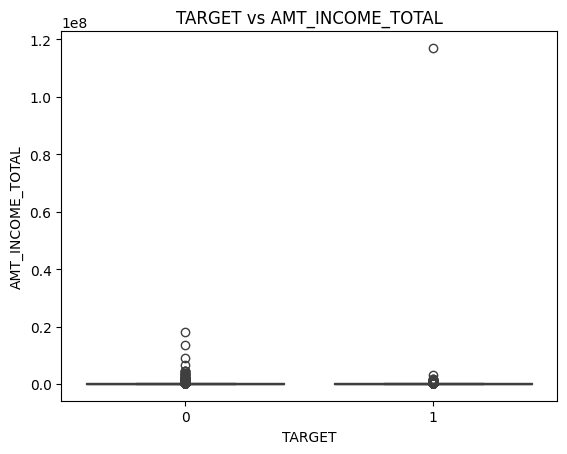

In [24]:
sns.boxplot(data=df_new, x="TARGET", y="AMT_INCOME_TOTAL")
plt.title("TARGET vs AMT_INCOME_TOTAL")
plt.show()

We see there are a few outliers when target is 1. Let's get rid of them.

In [25]:
print(df_new.shape)
df_new = df_new.loc[(df_new.AMT_INCOME_TOTAL <=1000000)].reset_index(drop=True)
print(df_new.shape)

(306956, 83)
(306706, 83)


### (iii) OBS_30_CNT_SOCIAL_CIRCLE

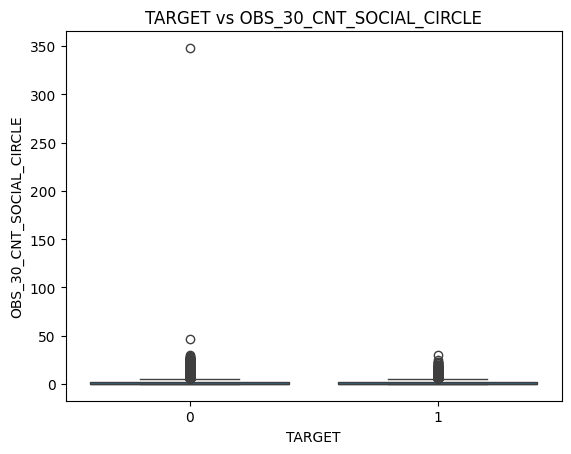

In [26]:
sns.boxplot(data=df_new, x="TARGET", y="OBS_30_CNT_SOCIAL_CIRCLE")
plt.title("TARGET vs OBS_30_CNT_SOCIAL_CIRCLE")
plt.show()

In [27]:
print(df_new.shape)
df_new = df_new.loc[(df_new.OBS_30_CNT_SOCIAL_CIRCLE < 20)].reset_index(drop=True)
print(df_new.shape)

(306706, 83)
(305560, 83)


In [28]:
print(df_new.shape, df.shape)

(305560, 83) (307511, 122)


This concludes the cleaning section and we have succesfully removed 2,000 data points that are outliers!

Let's now move to the data analysis section to find insights for business stakeholders.

# 3. Data Analysis

Let's pick a few variables for our analysis and extract insights in the form of conclusions.

### (i) Age vs Target
- **Question**: Does age of an individual have an impact on default rate?

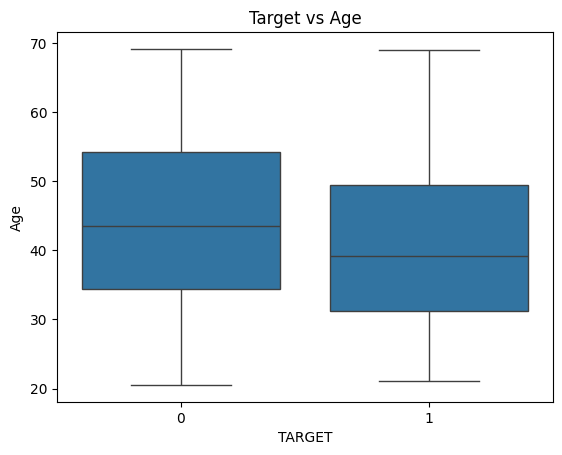

In [29]:
sns.boxplot(data=df_new, x="TARGET", y="Age")
plt.title("Target vs Age")

plt.show()

- **Observation**: We see the median age difference is ~5 years between defaulters and non-defaulters.
- **Conclusion**: People closer to the age of 35-40 range have a higher chance of defaulting.

### (ii) EXT_SOURCE_2 vs Target
- **Question**: Does the external variables have an impact on default rate?

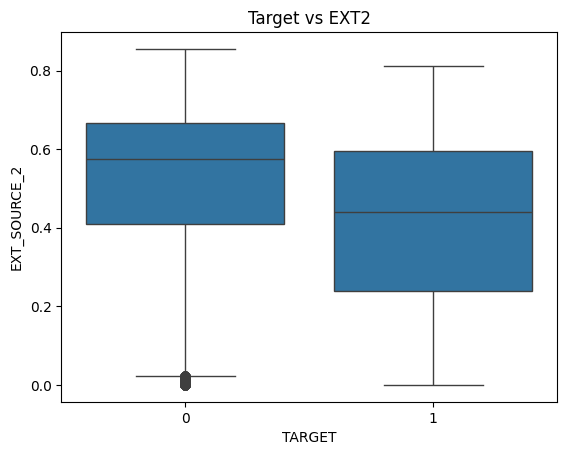

In [30]:
sns.boxplot(data=df_new, x="TARGET", y="EXT_SOURCE_2")
plt.title("Target vs EXT2")
plt.show()

- **Observation**: We observe that defaulters have lower median ext_source2 value than non-defaulters.
- **Conclusion**: It looks like it is an important feature coming from an external source. We should study this source more...

### (iii) EXT_SOURCE_3 vs Target
- **Question**: Does the external variable (EXT_SOURCE_3) have an impact on default rate?

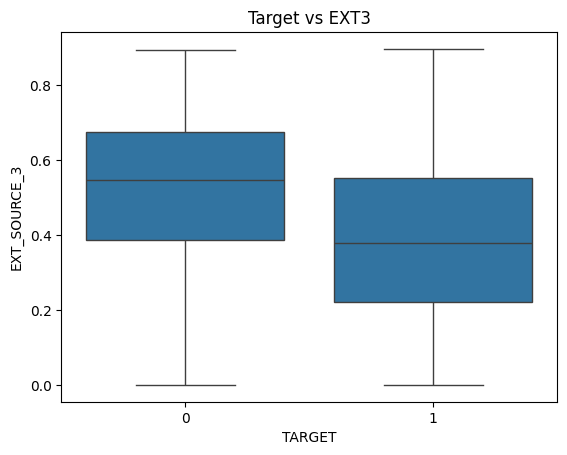

In [31]:
sns.boxplot(data=df_new, x="TARGET", y="EXT_SOURCE_3")
plt.title("Target vs EXT3")
plt.show()

- **Observation**: We observe that defaulters have much lower median value than non-defaulters. This difference is much more prominent in ext_source3 in comparison to ext_source2 feature.
- **Conclusion**: It looks like the features from external source are certainly valuable.

### (iv) DEF_30_CNT_SOCIAL_CIRCLE vs Target
- **Question**: Does the default rate of client's social surroundings hint at client's default rate?

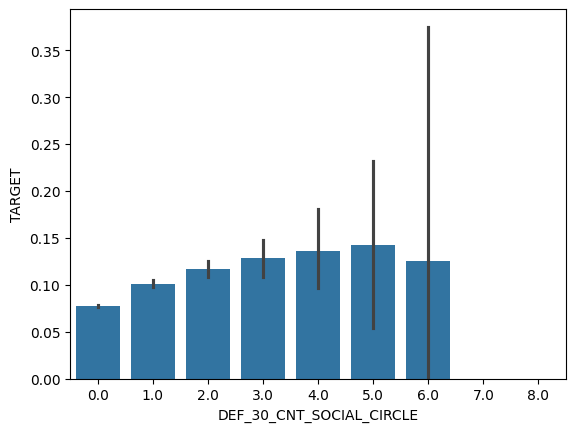

In [32]:
sns.barplot(data=df_new, x="DEF_30_CNT_SOCIAL_CIRCLE", y="TARGET")
plt.show()

- **Observation**: We observe that when there more than 3 defaulters in social circle, the rate of defaulting the loan goes higher by 50%. 
- **Conclusion**: However, the sample size is small and hence we should double check this conclusion through a few more analyses such as a bivariate analysis.

### (v) AMT_INCOME_TOTAL vs Target
- **Question**: Do high income individuals default?

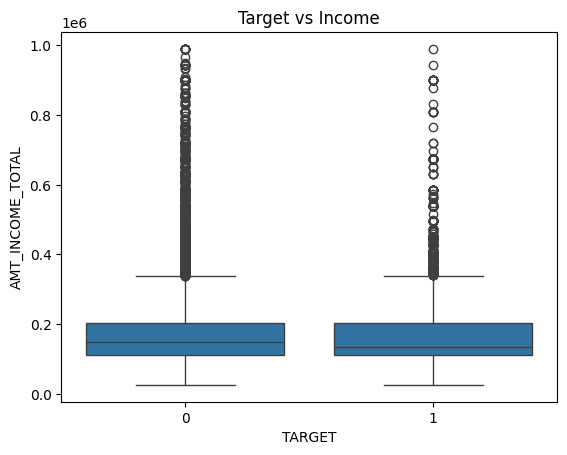

In [33]:
sns.boxplot(data=df_new, x="TARGET", y="AMT_INCOME_TOTAL")
plt.title("Target vs Income")
plt.show()

- **Observation**: We observe that there are a few outliers who are defaulters which is surprising!
- **Conclusion**: The assumption that high income clients pay back is not true as we see a few defaulters.

### (vi) REGION_RATING_CLIENT vs Target
- **Question**: Do higher number of defaulters exist in specific regions?

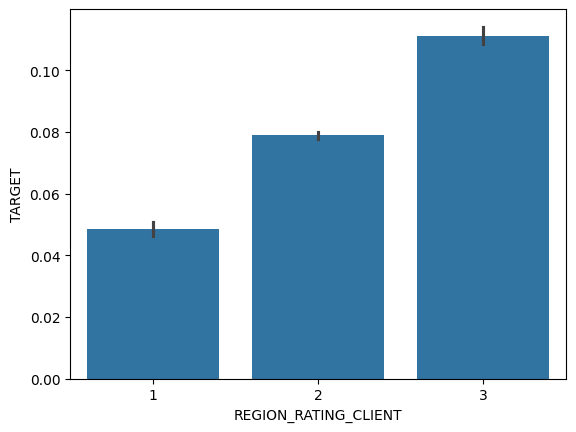

In [34]:
sns.barplot(data=df_new, x="REGION_RATING_CLIENT", y="TARGET")
plt.show()

- **Observation**: If the region rating of the client is 3, there is 2x the chance of defaulting the loan as compare to given region rating 1.
- **Conclusion**: Clients originating from region rating 3 must be carefully scrutinized before granting new loans.

### (vii) REG_CITY_NOT_WORK_CITY vs Target
- **Question**: There are a few customers who work at one city and registered at a different city. Are there any patterns to these clients?

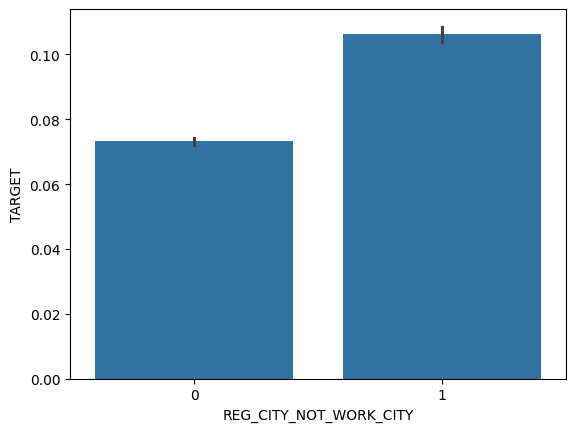

In [35]:
sns.barplot(data=df_new, x="REG_CITY_NOT_WORK_CITY", y="TARGET")
plt.show()

- **Observation**: If both the cities are not the same, there is a 40% higher chance of defaulting.
- **Conclusion**: Clients originating from the second bracket need to be carefully assessed for loans. Business team should keep this in mind while disbursing loan or assigning credit limits.

### (viii) Gender vs Target
- **Question**: Do men and women show different defaulting patterns?

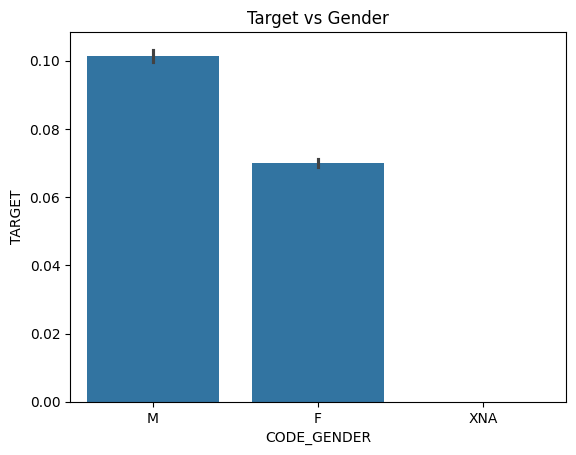

In [36]:
sns.barplot(data=df, x="CODE_GENDER", y="TARGET", orient="v")
plt.title("Target vs Gender")
plt.show()

- **Observation**: We observe that male population have a higher default rate than the female population.
- **Conclusion**: Before loan disbursal, we can check the combination of Gender (male) with other columns for deeper understanding.

### (ix) ORGANIZATION_TYPE vs Target
- **Question**: Do clients working in different organization types show different defaulting patterns?

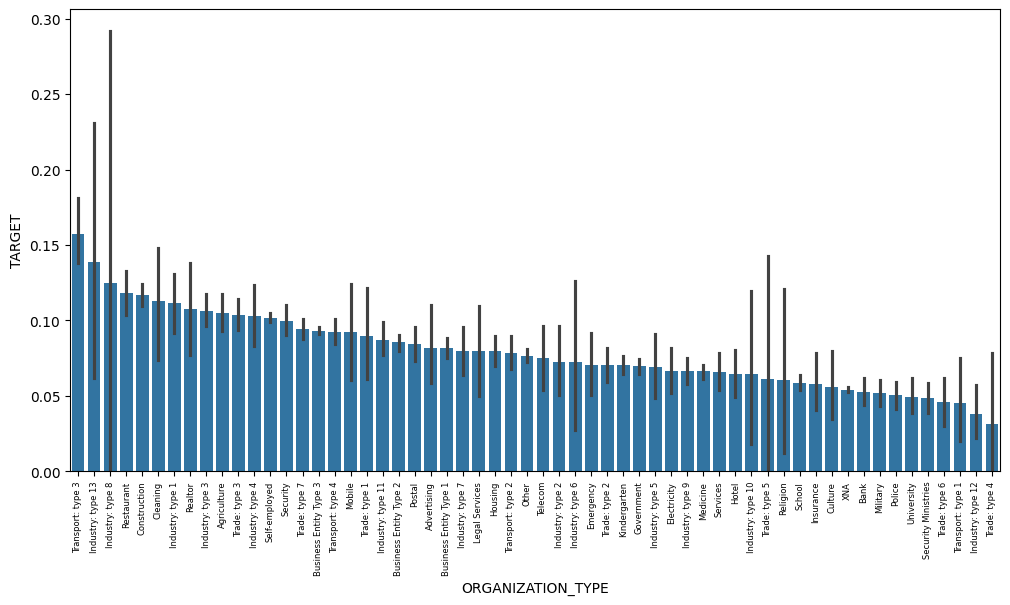

In [37]:
org_sort_ordered_list = list(df_new.groupby("ORGANIZATION_TYPE")['TARGET'].mean().sort_values(ascending=False).index)

plt.figure(figsize=(12, 6))
sns.barplot(data=df_new, x="ORGANIZATION_TYPE", y="TARGET", order=org_sort_ordered_list)
plt.xticks(fontsize=6, rotation=90)
plt.show()

- **Observation**: We see that there are a few organization types that show a much higher default rate than others.
- **Conclusion**: Before giving loans to cilents from Transport Type 3, Restaurants & Construction industries, we need to be cautious.

### (x) FLAG_EMP_PHONE vs Target
- **Question**: We see a few clients not providing work phone details. Do they exhibit a different pattern of default rate?

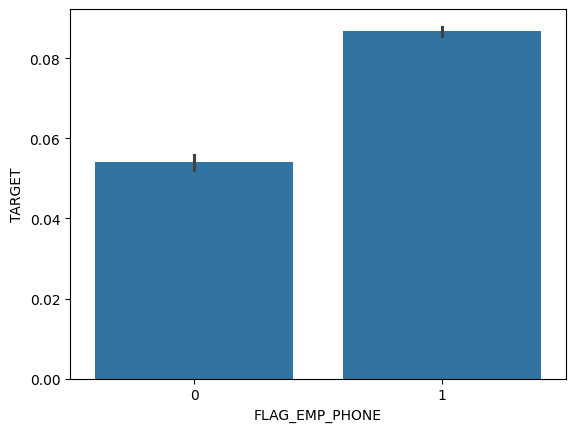

In [38]:
sns.barplot(data=df_new, x="FLAG_EMP_PHONE", y="TARGET")
plt.show()

- **Observation**: We observe that people who have do not provide work phone have ~30% more chances to default the loan.
- **Conclusion**: Business teams should seriously consider collecting work phone details prior to granting a loan. Otherwise, there's a higher chance of default.

# Multivariate analysis

### (xi) Age vs AMT_INCOME_TOTAL vs Target
- **Question**: What is the general defaulting trend across various age groups and income groups?

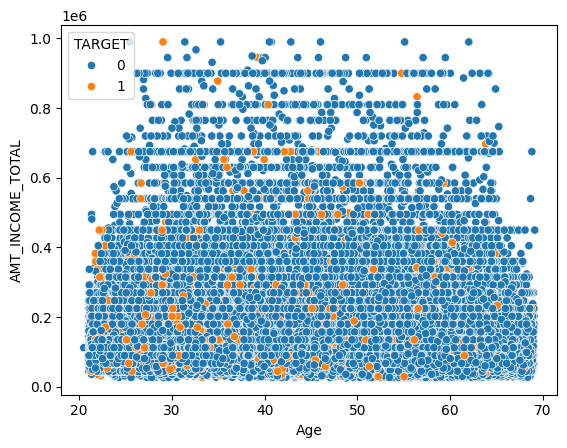

In [39]:
sns.scatterplot(data=df_new, x="Age", y="AMT_INCOME_TOTAL", hue="TARGET")
plt.show()

- **Observation**: At lower and higher age groups as well as at various income levels, there seems to be no specific pattern that we see.

### (xii) Target vs Previous Loan Application Rejections
- **Question**: Is there a pattern that we can see between previous loan application rejections vs latest default?

For doing this, we need to count the total number of rejections from the previous loan applications and then join it with the latest applications dataset.

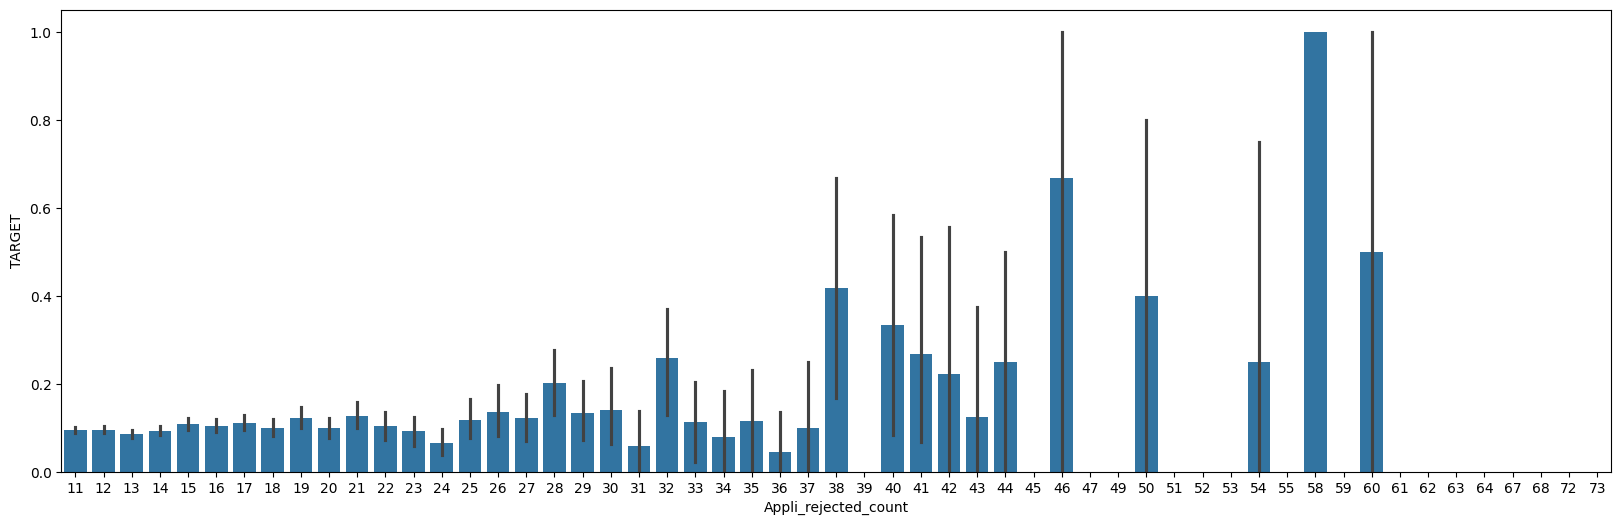

In [40]:
reject_counts_per_cust  = app.groupby("SK_ID_CURR")['CODE_REJECT_REASON'].count().reset_index()
df2 = df_new.merge(reject_counts_per_cust, on="SK_ID_CURR", how="left")
df2['Appli_rejected_count'] = df2.CODE_REJECT_REASON.fillna(0).astype("int16")
plt.figure(figsize=(20,6))
sns.barplot(data=df2.query("Appli_rejected_count>10"), x="Appli_rejected_count", y="TARGET")
plt.show()

- **Observation**: The plot shows consistent default rates until 27 loan application rejections and the default rate spikes up from 28 onwards.
- **Conclusion**: As one would assume, the default rate of a client is the same if the client had 2 rejections or 27 rejections. Beyond 27, the default rate spikes up.

### (xiii) Target vs Previous Loan Application Rejections's count and Income
- **Question**: Is there a pattern that we can see between previous loan application rejections vs Income and defaulters?

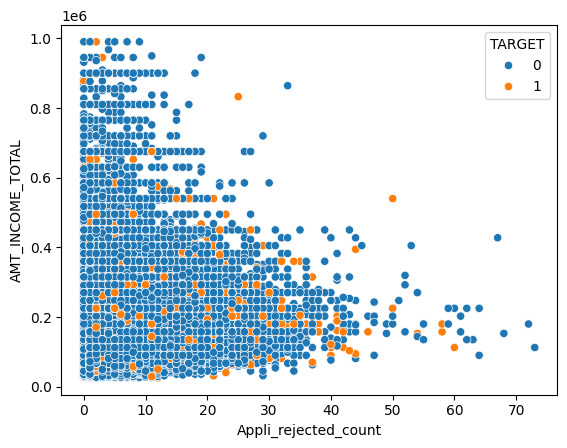

In [41]:
sns.scatterplot(data=df2, x="Appli_rejected_count", y="AMT_INCOME_TOTAL", hue="TARGET")
plt.show()

- **Observation**: The plot does not show any patters as we can see the data-points are scattered in the plot.

# 4. Model Creation and Evaluation

Identify categorical columns

In [42]:
categorical_cols = df.select_dtypes(include=['object']).columns
print("Categorical columns:", categorical_cols)


Categorical columns: Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE',
       'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'],
      dtype='object')


One-hot encode categorical variables

In [43]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

Split data into features (X) and target (y)

In [44]:
imputer = SimpleImputer(strategy="mean")  # Use 'mean' for numerical columns
X = df.drop(columns=['TARGET', 'SK_ID_CURR'])
X = imputer.fit_transform(X)  # Impute missing values in X
y = df['TARGET']

Split the data into training and testing sets

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize models

In [46]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
}

Train and evaluate each model

In [47]:
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    if y_pred_proba is not None:
        print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

--- Logistic Regression ---
Accuracy: 0.9196457606174258
Classification Report:
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     84841
           1       0.00      0.00      0.00      7413

    accuracy                           0.92     92254
   macro avg       0.46      0.50      0.48     92254
weighted avg       0.85      0.92      0.88     92254

ROC AUC Score: 0.617161811540812
Confusion Matrix:
 [[84841     0]
 [ 7413     0]]
--- Decision Tree ---
Accuracy: 0.8527109935612548
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     84841
           1       0.14      0.16      0.15      7413

    accuracy                           0.85     92254
   macro avg       0.53      0.54      0.54     92254
weighted avg       0.86      0.85      0.86     92254

ROC AUC Score: 0.5377830140879154
Confusion Matrix:
 [[77461  7380]
 [ 6208  1205]]
--- Random Forest ---
A